In [45]:
# data handling and analysis libraries
import geopandas as gpd
import pandas as pd
import numpy as np

# machine learning
from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
# map
import folium


load our main GeoDataFrame

In [2]:
gdf = gpd.read_file(r'data\shp\cells_finish.shp',crs="EPSG:4326")
gdf.head()

,fid,location,min_height,max_height,avg_height,std_height,nearest ci,week,year,fire,temperatur,humidity,pressure,wind_speed,ULcorner_L,ULcorner_1,geometry
0,1.0,C:/Users/Dell/OneDrive - Technion/××× ×××...,91.0,214.0,148.968819,25.747558,San Diego,39.0,2012.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-115.000417,"POLYGON ((-115.00042 33.00042, -114.90042 33.0..."
1,2.0,C:/Users/Dell/OneDrive - Technion/××× ×××...,141.0,463.0,205.685903,34.354413,San Diego,39.0,2012.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.900417,"POLYGON ((-114.90042 33.00042, -114.80042 33.0..."
2,3.0,C:/Users/Dell/OneDrive - Technion/××× ×××...,165.0,592.0,246.467083,33.330296,San Diego,39.0,2012.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.800417,"POLYGON ((-114.80042 33.00042, -114.70042 33.0..."
3,4.0,C:/Users/Dell/OneDrive - Technion/××× ×××...,61.0,521.0,230.628333,47.022054,San Diego,39.0,2012.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.700417,"POLYGON ((-114.70042 33.00042, -114.60042 33.0..."
4,5.0,C:/Users/Dell/OneDrive - Technion/××× ×××...,48.0,400.0,164.990556,49.978685,San Diego,39.0,2012.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.600417,"POLYGON ((-114.60042 33.00042, -114.50042 33.0..."


arrange data for learning

In [3]:
gdf.columns

Index(['fid', 'location', 'min_height', 'max_height', 'avg_height',
       'std_height', 'nearest ci', 'week', 'year', 'fire', 'temperatur',
       'humidity', 'pressure', 'wind_speed', 'ULcorner_L', 'ULcorner_1',
       'geometry'],
      dtype='object')

In [4]:
# fixing some problem with colomns names (happend in the export of the gdf)
gdf = gdf.rename(columns={"ULcorner_L": "ULcorner_Lat", "ULcorner_1": "ULcorner_Long"}) 

In [5]:
gdf = gdf.drop(columns=['fid', 'location', 'year', 'nearest ci'])

In [6]:
gdf.head()


,min_height,max_height,avg_height,std_height,week,fire,temperatur,humidity,pressure,wind_speed,ULcorner_Lat,ULcorner_Long,geometry
0,91.0,214.0,148.968819,25.747558,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-115.000417,"POLYGON ((-115.00042 33.00042, -114.90042 33.0..."
1,141.0,463.0,205.685903,34.354413,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.900417,"POLYGON ((-114.90042 33.00042, -114.80042 33.0..."
2,165.0,592.0,246.467083,33.330296,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.800417,"POLYGON ((-114.80042 33.00042, -114.70042 33.0..."
3,61.0,521.0,230.628333,47.022054,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.700417,"POLYGON ((-114.70042 33.00042, -114.60042 33.0..."
4,48.0,400.0,164.990556,49.978685,39.0,NaN,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.600417,"POLYGON ((-114.60042 33.00042, -114.50042 33.0..."


In [7]:
# replace nans with zeros in the label colomn
gdf['fire'] = gdf['fire'].fillna(0)

In [8]:
gdf.head()

,min_height,max_height,avg_height,std_height,week,fire,temperatur,humidity,pressure,wind_speed,ULcorner_Lat,ULcorner_Long,geometry
0,91.0,214.0,148.968819,25.747558,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-115.000417,"POLYGON ((-115.00042 33.00042, -114.90042 33.0..."
1,141.0,463.0,205.685903,34.354413,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.900417,"POLYGON ((-114.90042 33.00042, -114.80042 33.0..."
2,165.0,592.0,246.467083,33.330296,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.800417,"POLYGON ((-114.80042 33.00042, -114.70042 33.0..."
3,61.0,521.0,230.628333,47.022054,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.700417,"POLYGON ((-114.70042 33.00042, -114.60042 33.0..."
4,48.0,400.0,164.990556,49.978685,39.0,0.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.600417,"POLYGON ((-114.60042 33.00042, -114.50042 33.0..."


Preprocess: split data to features and labels

In [9]:
X = pd.DataFrame(gdf.drop(columns=['fire','geometry']))
y = pd.DataFrame(gdf['fire'])
y.head()

,fire
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [10]:
# the test set will be the the last year we have data for
X_train = X.loc[:121680]
X_test = X.loc[121680:]
y_train = y.loc[:121680]
y_test = y.loc[121680:]


In [11]:
X_train.head()

,min_height,max_height,avg_height,std_height,week,temperatur,humidity,pressure,wind_speed,ULcorner_Lat,ULcorner_Long
0,91.0,214.0,148.968819,25.747558,39.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-115.000417
1,141.0,463.0,205.685903,34.354413,39.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.900417
2,165.0,592.0,246.467083,33.330296,39.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.800417
3,61.0,521.0,230.628333,47.022054,39.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.700417
4,48.0,400.0,164.990556,49.978685,39.0,294.500153,70.148387,1014.387097,1.187097,33.000417,-114.600417


Feature Scaling

In [12]:
scalar = StandardScaler()
scalar.fit(X_train)

X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

### Training ANN using Scikit learn

Training and Predictions



In [13]:
mlps = []
# mlps.append(MLPClassifier(hidden_layer_sizes=3, max_iter=1000))
# mlps.append(MLPClassifier(hidden_layer_sizes=10, max_iter=1000))
mlps.append(MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000))

predictions = []
for i,mlp in enumerate(mlps):
    mlp.fit(X_train, y_train.values.ravel())
    predictions.append(mlp.predict(X_test))

Evaluate the Algorithm

In [14]:
for prediction in predictions:
    print(confusion_matrix(y_test,prediction))
    print(classification_report(y_test,prediction))
    print('_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ')


[[52924     0]
 [ 1156     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.00      0.00      0.00      1156

    accuracy                           0.98     54080
   macro avg       0.49      0.50      0.49     54080
weighted avg       0.96      0.98      0.97     54080

_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


### Training Random forest using Scikit learn

In [15]:
forest_clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[52897    27]
 [ 1139    17]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.39      0.01      0.03      1156

    accuracy                           0.98     54080
   macro avg       0.68      0.51      0.51     54080
weighted avg       0.97      0.98      0.97     54080



Text(0.5, 1.0, 'Visualizing Features Importance')

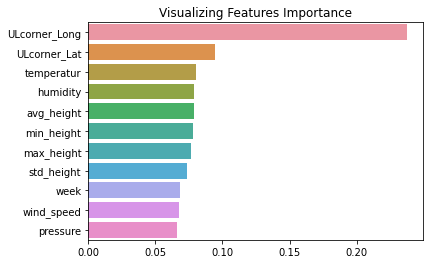

In [16]:
feature_importance = pd.Series(forest_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Visualizing Features Importance')

### Training Random Forest using XGBoost


In [17]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 1, n_estimators = 100)
xg_reg.fit(X_train,y_train)

y_pred = xg_reg.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[52924     0]
 [ 1156     0]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.00      0.00      0.00      1156

    accuracy                           0.98     54080
   macro avg       0.49      0.50      0.49     54080
weighted avg       0.96      0.98      0.97     54080



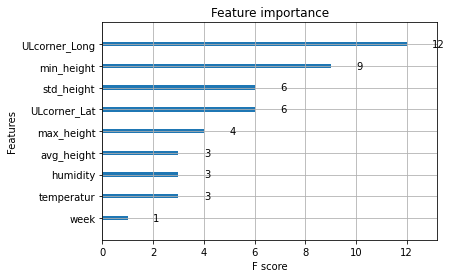

In [18]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

We can see in both random forest imlementations that the Uper Left Corner Longitude
is the most important feature whitch seems reasonble according to the fires locations.

In [19]:
# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

### Data Analysis

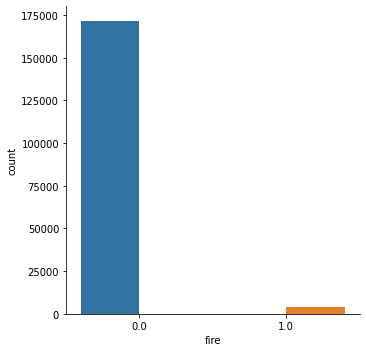

In [20]:
sns.catplot(x = "fire", hue="fire", kind="count", data=gdf)

We can see we have highly imbalanced classes

This means that the heigh accuracy we got for the results is missleading.
We didn't realy predicted any fires but just labeld "non fire" all the time.
The scikit Random forest is the only alghoritem so far that actually predicted some of the fires

### Handling imbalanced classes

We will try upsampling

In [21]:
df_train = gdf.loc[:121680]
# Separate majority and minority classes
df_majority = df_train[df_train['fire']==0]
df_minority = df_train[df_train['fire']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=118615,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled.fire.value_counts()

1.0    118615
0.0    118615
Name: fire, dtype: int64

In [22]:
y_train_upsampled = df_upsampled.fire
X_train_upsampled = df_upsampled.drop(columns=['fire','geometry'], axis=1)

In [23]:
X_test = X.loc[121680:]

scalar = StandardScaler()
scalar.fit(X_train_upsampled)

X_train_upsampled = scalar.transform(X_train_upsampled)
X_test_upsampled = scalar.transform(X_test)

In [24]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train_upsampled,y_train_upsampled)

y_pred = xg_reg.predict(X_test_upsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[37947 14977]
 [  206   950]]
              precision    recall  f1-score   support

         0.0       0.99      0.72      0.83     52924
         1.0       0.06      0.82      0.11      1156

    accuracy                           0.72     54080
   macro avg       0.53      0.77      0.47     54080
weighted avg       0.97      0.72      0.82     54080



In [25]:
forest_clf = RandomForestClassifier(n_estimators=100,class_weight='balanced')
forest_clf.fit(X_train_upsampled, y_train_upsampled)
y_pred = forest_clf.predict(X_test_upsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))



[[52734   190]
 [ 1094    62]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     52924
         1.0       0.25      0.05      0.09      1156

    accuracy                           0.98     54080
   macro avg       0.61      0.53      0.54     54080
weighted avg       0.96      0.98      0.97     54080



We will try Down sample

In [26]:
df_train = gdf.loc[:121680]
# Separate majority and minority classes
df_majority = df_train[df_train['fire']==0]
df_minority = df_train[df_train['fire']==1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=3066,     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled.fire.value_counts()


1.0    3066
0.0    3066
Name: fire, dtype: int64

In [27]:
y_train_downsampled = df_downsampled.fire
X_train_downsampled = df_downsampled.drop(columns=['fire','geometry'], axis=1)

In [28]:
X_test = X.loc[121680:]

scalar = StandardScaler()
scalar.fit(X_train_downsampled)

X_train_downsampled = scalar.transform(X_train_downsampled)
X_test_downsampled = scalar.transform(X_test)

random forest using XGBoost

In [61]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 500)
xg_reg.fit(X_train_downsampled,y_train_downsampled)

y_pred = xg_reg.predict(X_test_downsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[41082 11842]
 [  217   939]]
              precision    recall  f1-score   support

         0.0       0.99      0.78      0.87     52924
         1.0       0.07      0.81      0.13      1156

    accuracy                           0.78     54080
   macro avg       0.53      0.79      0.50     54080
weighted avg       0.98      0.78      0.86     54080



Best: -0.426222 using {'learning_rate': 0.3}
-0.690438 (0.000163) with: {'learning_rate': 0.0001}
-0.668280 (0.001568) with: {'learning_rate': 0.001}
-0.549806 (0.010664) with: {'learning_rate': 0.01}
-0.445221 (0.022682) with: {'learning_rate': 0.1}
-0.430571 (0.026769) with: {'learning_rate': 0.2}
-0.426222 (0.026901) with: {'learning_rate': 0.3}
-0.432738 (0.030712) with: {'learning_rate': 0.4}
-0.439401 (0.033076) with: {'learning_rate': 0.5}


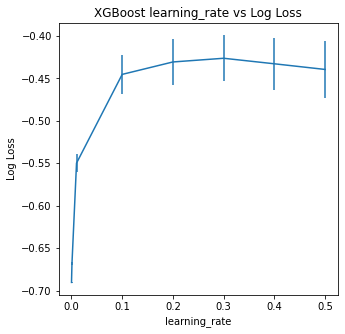

In [58]:
# taken from here:
# https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

# grid search
model = xgb.XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_downsampled, y_train_downsampled)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs Log Loss")
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('learning_rate.png')

Interestingly, we can see that the best learning rate was 0.3.

This is a high learning rate and it suggest that perhaps the default number of trees of 100 is too low and needs to be increased.

### Tuning Learning Rate and the Number of Trees in

Best: -0.423199 using {'learning_rate': 0.2, 'n_estimators': 200}
-0.690438 (0.000163) with: {'learning_rate': 0.0001, 'n_estimators': 100}
-0.687780 (0.000325) with: {'learning_rate': 0.0001, 'n_estimators': 200}
-0.685173 (0.000485) with: {'learning_rate': 0.0001, 'n_estimators': 300}
-0.682616 (0.000644) with: {'learning_rate': 0.0001, 'n_estimators': 400}
-0.680108 (0.000801) with: {'learning_rate': 0.0001, 'n_estimators': 500}
-0.668280 (0.001568) with: {'learning_rate': 0.001, 'n_estimators': 100}
-0.647978 (0.002955) with: {'learning_rate': 0.001, 'n_estimators': 200}
-0.630542 (0.004644) with: {'learning_rate': 0.001, 'n_estimators': 300}
-0.614785 (0.006264) with: {'learning_rate': 0.001, 'n_estimators': 400}
-0.600338 (0.007361) with: {'learning_rate': 0.001, 'n_estimators': 500}
-0.549806 (0.010664) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.504861 (0.015345) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.486992 (0.017803) with: {'learning_rate': 0.01, 'n_e

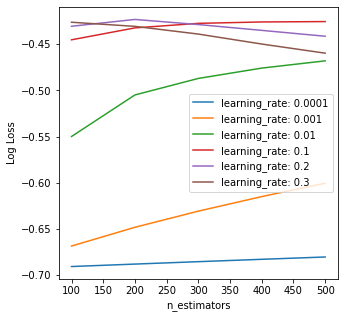

In [53]:
model = xgb.XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_downsampled, y_train_downsampled)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')

we can see that for learning rate = 0.1 we plato at arround 300 estimators.



Best: -0.447244 using {'learning_rate': 0.01, 'n_estimators': 1000}
-0.549806 (0.010664) with: {'learning_rate': 0.01, 'n_estimators': 100}
-0.504861 (0.015345) with: {'learning_rate': 0.01, 'n_estimators': 200}
-0.486992 (0.017803) with: {'learning_rate': 0.01, 'n_estimators': 300}
-0.475823 (0.019240) with: {'learning_rate': 0.01, 'n_estimators': 400}
-0.467973 (0.019727) with: {'learning_rate': 0.01, 'n_estimators': 500}
-0.462073 (0.020451) with: {'learning_rate': 0.01, 'n_estimators': 600}
-0.457522 (0.021363) with: {'learning_rate': 0.01, 'n_estimators': 700}
-0.453572 (0.021843) with: {'learning_rate': 0.01, 'n_estimators': 800}
-0.450133 (0.022321) with: {'learning_rate': 0.01, 'n_estimators': 900}
-0.447244 (0.022825) with: {'learning_rate': 0.01, 'n_estimators': 1000}


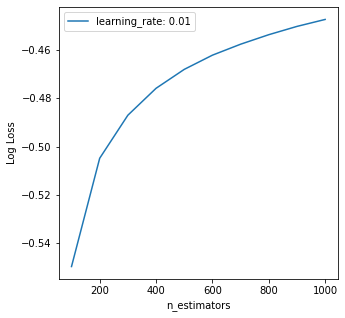

In [59]:
model = xgb.XGBClassifier()
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
learning_rate = [0.01]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_downsampled, y_train_downsampled)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.savefig('n_estimators_vs_learning_rate.png')

In [39]:
y_prob = xg_reg.predict_proba(X_test_downsampled)

random forest using scikit learn

In [30]:
forest_clf = RandomForestClassifier(n_estimators=100)
forest_clf.fit(X_train_downsampled, y_train_downsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
y_pred = forest_clf.predict(X_test_downsampled)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[40799 12125]
 [  237   919]]
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87     52924
         1.0       0.07      0.79      0.13      1156

    accuracy                           0.77     54080
   macro avg       0.53      0.78      0.50     54080
weighted avg       0.97      0.77      0.85     54080



We will also predict probability to create fire risk map

In [32]:
y_prob = forest_clf.predict_proba(X_test_downsampled)

Text(0.5, 1.0, 'Visualizing Features Importance')

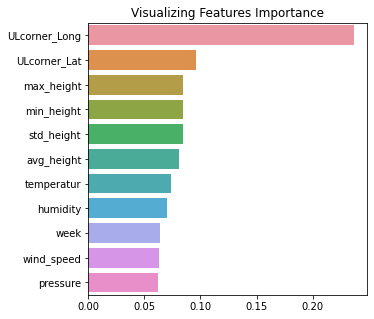

In [33]:
feature_importance = pd.Series(forest_clf.feature_importances_,index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Visualizing Features Importance')

ANN using scikit learn

In [34]:
mlp = MLPClassifier(hidden_layer_sizes=(10,10,10), max_iter=1000)

mlp.fit(X_train_downsampled, y_train_downsampled.values.ravel())
prediction = mlp.predict(X_test_downsampled)
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))

[[40243 12681]
 [  312   844]]
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86     52924
         1.0       0.06      0.73      0.11      1156

    accuracy                           0.76     54080
   macro avg       0.53      0.75      0.49     54080
weighted avg       0.97      0.76      0.85     54080



We can already see both in the usmapling and in the downsampling, better results. We now predict heigh percent of the fires but and this is most important for us

Now when we know we are able to make some predictions, we need to find better ways to evaluate our predictions and figure out which algorithm give us the best results and what we can do to improve these results.
First of all we will visualize our results to get a better picture of what we are getting. 

### visualization


In [35]:
fires = gpd.read_file(r'data/fires_2012-15.shp')
fires.head()

,Unnamed_ 0,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYS,SOURCE_S_1,NWCG_REPOR,NWCG_REP_1,NWCG_REP_2,SOURCE_REP,...,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESC,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,geometry
0,1567432,1567433,201433714,FS-1503920,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,...,34.204167,-117.808333,5.0,USFS,CA,037,37.0,Los Angeles,b'\x00\x01\xad\x10\x00\x00x\'\xb8\xbb\xbbs]\xc...,POINT (-117.80833 34.20417)
1,1567433,1567434,201433715,FS-1507944,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,...,34.345278,-117.928889,5.0,USFS,CA,037,37.0,Los Angeles,b'\x00\x01\xad\x10\x00\x00\xb8\nc\xear{]\xc0`\...,POINT (-117.92889 34.34528)
2,1567434,1567435,201433716,FS-1510402,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,...,34.548056,-118.671667,5.0,USFS,CA,037,37.0,Los Angeles,b'\x00\x01\xad\x10\x00\x00\xa4]3\x96\xfc\xaa]\...,POINT (-118.67167 34.54806)
3,1567435,1567436,201433717,FS-1503567,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,...,34.174722,-117.672500,5.0,USFS,CA,071,71.0,San Bernardino,b'\x00\x01\xad\x10\x00\x00\xd4\xa3p=\nk]\xc0pd...,POINT (-117.67250 34.17472)
4,1567436,1567437,201433718,FS-1504047,FED,FS-FIRESTAT,FS,USCAANF,Angeles National Forest,0501,...,34.489444,-118.285833,14.0,MISSING/NOT SPECIFIED,CA,037,37.0,Los Angeles,b'\x00\x01\xad\x10\x00\x008\x1d\xe1\x17K\x92]\...,POINT (-118.28583 34.48944)


In [36]:
# y_prob[0:1040,1].shape

In [37]:
def visualize_prediction(week):
    # train and test fires of this week
    temp_fires = fires[fires['DISCOVER_1']//7 == week]
    train_fires = temp_fires[temp_fires['FIRE_YEAR']<2015]
    test_fires = temp_fires[temp_fires['FIRE_YEAR'] == 2015]

    # fire propability predictions
    gdf_for_visualization = gdf.loc[121680+1040*week:121680+1039+1040*week,:]
    gdf_for_visualization['fire_risk'] = y_prob[1040*week:1040*week+1040,1]
    gdf_for_visualization['index'] = gdf_for_visualization.index
    gdf_for_visualization.head()

    # centroid for map
    x_map=gdf_for_visualization.centroid.x.mean()
    y_map=gdf_for_visualization.centroid.y.mean()

    # create folium map
    m = folium.Map(location=[y_map, x_map],
                        tiles = "Stamen Terrain",
                        zoom_start = 5)

    # adding colors by prediction probability values
    m.choropleth(
    geo_data=gdf_for_visualization,
    name='Choropleth',
    data=gdf_for_visualization,
    columns=['index','fire_risk'],
    key_on="feature.properties.index",
    fill_color='OrRd',
    # threshold_scale=myscale,
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='fire risk',
    )
    folium.LayerControl().add_to(m)

    # add intercative cell data
    style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.1, 
                            'weight': 0.1}
    highlight_function = lambda x: {'fillColor': '#000000', 
                                    'color':'#000000', 
                                    'fillOpacity': 0.50, 
                                    'weight': 0.1}
    NIL = folium.features.GeoJson(
        gdf_for_visualization,
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function, 
        tooltip=folium.features.GeoJsonTooltip(
            fields=['index','fire_risk','humidity','temperatur','avg_height'],
            aliases=['area id: ','fire_risk: ','humidity: ','temperature: ','avg height: '],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
    )
    m.add_child(NIL)
    m.keep_in_front(NIL)
    folium.LayerControl().add_to(m)

    # add fires markers

    for index in train_fires.index:
        folium.CircleMarker( location=[ train_fires.loc[index,'LATITUDE'], train_fires.loc[index,'LONGITUDE'] ], color ='#43d9de', radius=2 ).add_to(m)
    for index in test_fires.index:
        folium.CircleMarker( location=[ test_fires.loc[index,'LATITUDE'], test_fires.loc[index,'LONGITUDE'] ], color ='#2f12b3', radius=3 ).add_to(m)

    return m

We have now a function that gets a week number and returns map od the predictions.

Blue circles are real fires from the test set of the chosen week and the cyan circles are the train fires from that week in previous years   

In [41]:
m = visualize_prediction(30)
m